In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [2]:
from sklearn.model_selection import cross_val_score,KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb
from xgboost import XGBRFRegressor

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import matplotlib.pylab as plt
import category_encoders as ce
import sklearn
from matplotlib import pyplot as plt

## Scoring function for train set

In [3]:
def scoring(clf, X, y):
    kf = KFold(5, shuffle=True, random_state=19).get_n_splits(X)
    cvs = (cross_val_score(clf, X, y, cv=kf,scoring='neg_mean_squared_log_error')*(-1))**0.5
    print('Mean: {}, std: {}'.format(cvs.mean(),cvs.std()))
    return cvs

## Baseline model

### Data loading

In [4]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Baseline XGBoost and catboost

In [5]:
feature_list = list(test.columns)
#X_train = pd.DataFrame()

In [6]:
def feature_split(train):
    quant_ftr = []
    cat_ftr = []
    for feature in train.columns:
        if train[feature].dtype in ['float64', 'int64']:
            quant_ftr.append(feature)
        else:
            cat_ftr.append(feature)
    return quant_ftr,cat_ftr


#### Label encodig for categorical features

In [7]:


def label_encode(train, ):
    quant_ftr, cat_ftr = feature_split(train)
    encoder = LabelEncoder()
    encoded = train[cat_ftr].fillna('NAN').apply(encoder.fit_transform)
    data = train[quant_ftr].join(encoded)
    return data
y = train['SalePrice']
train_l = label_encode(train)
test_l = label_encode(test)

In [8]:
train_l.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,1,2,5,5,2,3,4,1,8,4
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,1,2,5,5,2,3,4,1,8,4
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,1,2,5,5,2,3,4,1,8,4
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,5,3,5,5,2,3,4,1,8,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,1,2,5,5,2,3,4,1,8,4


In [9]:
lgbm = lgb.LGBMRegressor()
cat = CatBoostRegressor(random_state=42, silent=True)
xgboost = xgb.XGBRegressor(random_state=42)

In [10]:
baseline = scoring(xgboost, train_l[feature_list].fillna(0),y).mean()

[23:56:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean: 0.1327236919846402, std: 0.010520919871376211


In [11]:
#cat_baseline = scoring(cat, train_l[feature_list].fillna(0),y).mean()

In [12]:
def update_baseline(baseline = baseline,clf = xgboost, train = train_l, ftr = feature_list, y = y):
    scr = scoring(clf, train_l[ftr],y).mean()
    diff = round((baseline - scr)/baseline*100,2)
    if baseline<scr:
        print('Getting WORSE at {}% (old = {})'.format(diff, baseline))
        return baseline
    else:
        print('Getting BETTER at {}% (old = {})'.format(diff,baseline))
        return scr


## Feature Engeneering


### Garage

In [13]:
feature_list = list(test.columns)

In [14]:
garage = ['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond','GarageArea','GarageCars']

In [15]:
train[garage].head()

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,GarageArea,GarageCars
0,Attchd,2003.0,RFn,TA,TA,548,2
1,Attchd,1976.0,RFn,TA,TA,460,2
2,Attchd,2001.0,RFn,TA,TA,608,2
3,Detchd,1998.0,Unf,TA,TA,642,3
4,Attchd,2000.0,RFn,TA,TA,836,3


In [16]:
garage_after = lambda x:1 if (x['GarageYrBlt'] - x['YearBuilt']) >0 else 0
train['GarageAfter'] = train.apply(garage_after, axis = 1)
test['GarageAfter'] = test.apply(garage_after, axis = 1)

In [17]:
train['Garage'] = train['GarageType']+train['GarageAfter'].astype(str)+train['GarageFinish']+train['GarageQual']+train['GarageCond']
test['Garage'] = test['GarageType']+test['GarageAfter'].astype(str)+test['GarageFinish']+test['GarageQual']+test['GarageCond']

In [18]:
feature_list.append('Garage')

In [19]:
garage.append('Garage')

In [20]:
train_l = label_encode(train)
test_l = label_encode(test)

In [21]:
baseline = update_baseline(baseline=baseline, ftr = list(test.columns))

[23:56:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean: 0.13071209922174204, std: 0.01098339541028803
Getting BETTER at 1.52% (old = 0.1327236919846402)


In [22]:
#cat_baseline =  update_baseline(clf = cat, ftr = list(test.columns),baseline = cat_baseline)

### Basement

In [23]:
basement = ['BsmtCond','BsmtExposure','BsmtFinSF1','BsmtFinSF2','BsmtFinType1','BsmtFinType2','BsmtFullBath','BsmtHalfBath',
           'BsmtQual','BsmtUnfSF','TotalBsmtSF']

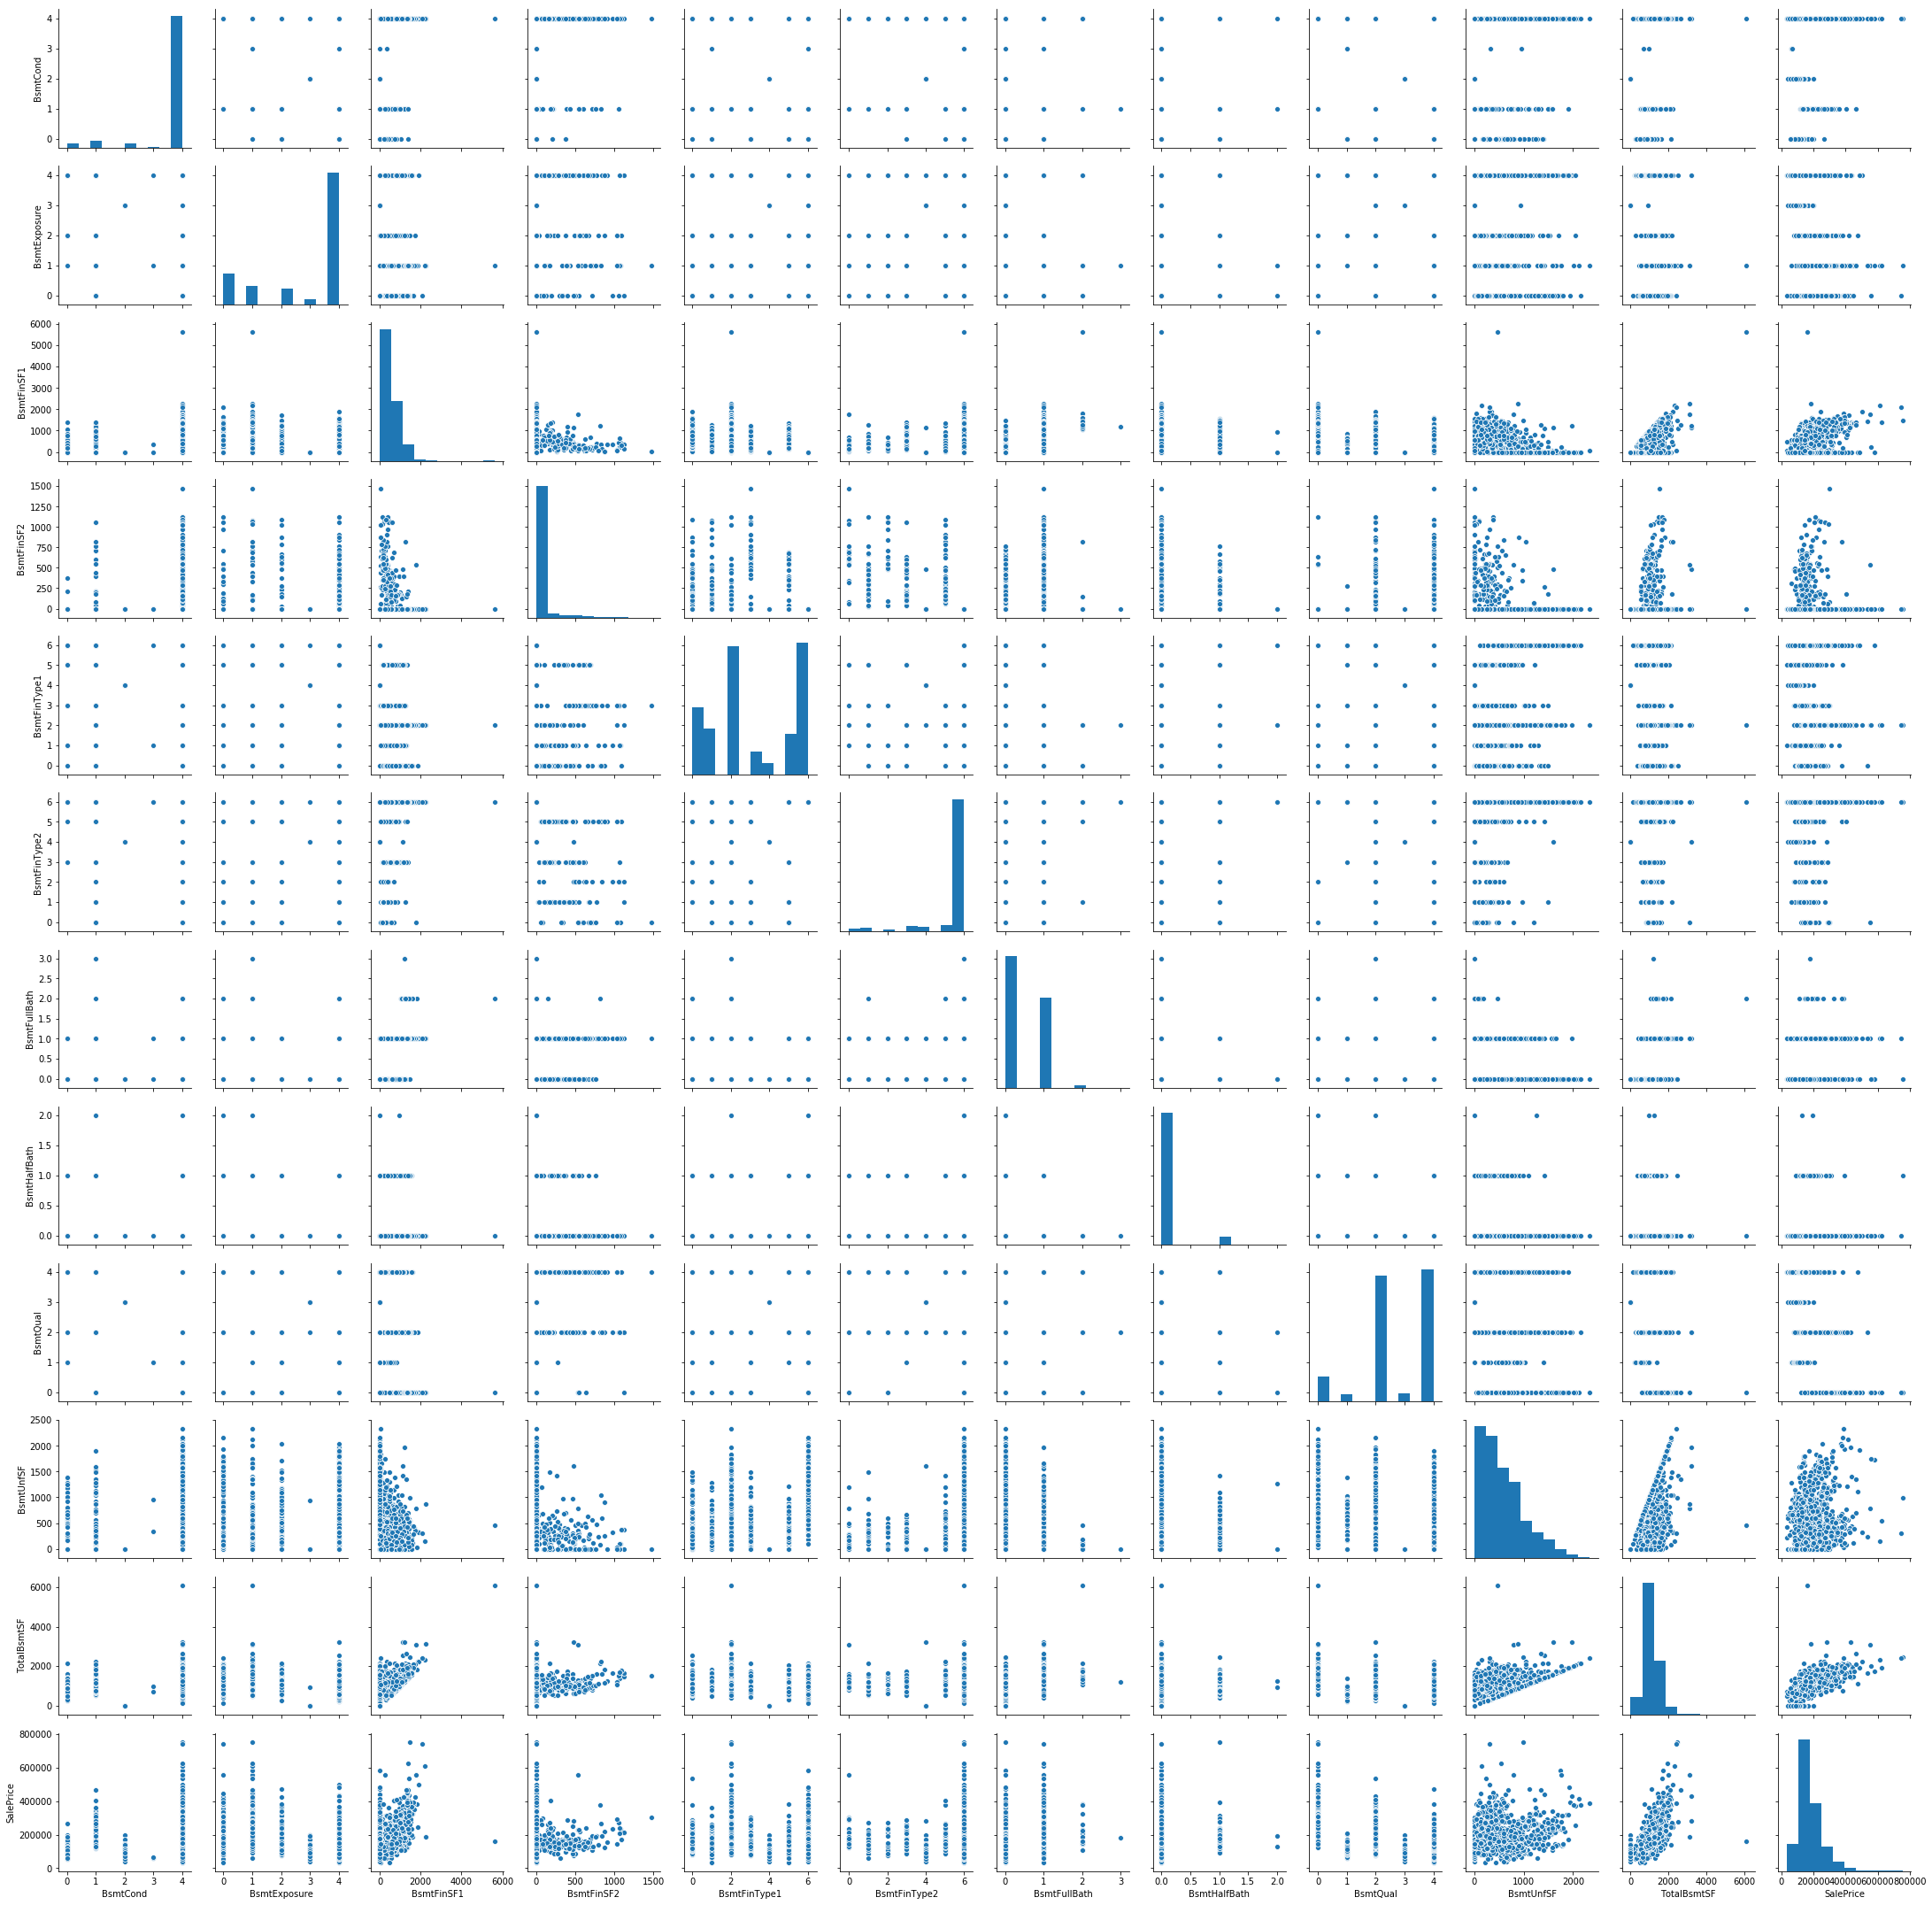

In [24]:
sns.pairplot(train_l[basement+['SalePrice']])

In [25]:
train[basement+['SalePrice']].head(10)

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF,SalePrice
0,TA,No,706,0,GLQ,Unf,1,0,Gd,150,856,208500
1,TA,Gd,978,0,ALQ,Unf,0,1,Gd,284,1262,181500
2,TA,Mn,486,0,GLQ,Unf,1,0,Gd,434,920,223500
3,Gd,No,216,0,ALQ,Unf,1,0,TA,540,756,140000
4,TA,Av,655,0,GLQ,Unf,1,0,Gd,490,1145,250000
5,TA,No,732,0,GLQ,Unf,1,0,Gd,64,796,143000
6,TA,Av,1369,0,GLQ,Unf,1,0,Ex,317,1686,307000
7,TA,Mn,859,32,ALQ,BLQ,1,0,Gd,216,1107,200000
8,TA,No,0,0,Unf,Unf,0,0,TA,952,952,129900
9,TA,No,851,0,GLQ,Unf,1,0,TA,140,991,118000


### YearRemodAdd

In [26]:
train[['YearRemodAdd','YearBuilt']].head()

,YearRemodAdd,YearBuilt
0,2003,2003
1,1976,1976
2,2002,2001
3,1970,1915
4,2000,2000


In [27]:
train['Remoded'] = train.apply(lambda x: 1 if x['YearRemodAdd']!=x['YearBuilt'] else 0, axis = 1)
test['Remoded'] = test.apply(lambda x: 1 if x['YearRemodAdd']!=x['YearBuilt'] else 0, axis = 1)

In [28]:
del train['YearRemodAdd']
del test['YearRemodAdd']

In [29]:
ftr = list(test.columns)
train_l = label_encode(train)
baseline = update_baseline(baseline=baseline, ftr = ftr)

[23:57:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean: 0.13042093128500262, std: 0.009877243674548885
Getting BETTER at 0.22% (old = 0.13071209922174204)


In [30]:
#cat_baseline =  update_baseline(clf = cat, ftr = list(test.columns),baseline = cat_baseline)

### Pool

In [31]:
train[train.PoolArea>0][['PoolQC','PoolArea','LotArea']].head()

,PoolQC,PoolArea,LotArea
197,Ex,512,25419
810,Fa,648,10140
1170,Gd,576,9880
1182,Ex,555,15623
1298,Gd,480,63887


In [32]:
train['PoolQC'].value_counts()

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64

In [33]:
del train['PoolArea']
del test['PoolArea']
del train['PoolQC']
del test['PoolQC']

In [34]:
ftr = list(test.columns)

train_l = label_encode(train)
baseline = update_baseline(baseline=baseline, ftr = ftr)
#cat_baseline =  update_baseline(clf = cat, ftr = list(test.columns),baseline = cat_baseline)

[23:57:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean: 0.12981976631107967, std: 0.010440990995596127
Getting BETTER at 0.46% (old = 0.13042093128500262)


### Misc

In [35]:
train[train.MiscVal>0][['MiscFeature','MiscVal']].head()

,MiscFeature,MiscVal
5,Shed,700
7,Shed,350
16,Shed,700
17,Shed,500
51,Shed,400


In [36]:
train.MiscFeature.value_counts()

Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

In [37]:
ftr = list(test.columns)
ftr.remove('MiscFeature')
train_l = label_encode(train)
baseline = update_baseline(baseline=baseline, ftr = ftr)

[23:57:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean: 0.12981976631107967, std: 0.010440990995596127
Getting BETTER at 0.0% (old = 0.12981976631107967)


In [38]:
del train['MiscFeature']
del test['MiscFeature']

In [39]:
ftr = list(test.columns)
ftr.remove('MiscVal')
train_l = label_encode(train)
baseline = update_baseline(baseline=baseline, ftr = ftr)

[23:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean: 0.12981976631107967, std: 0.010440990995596127
Getting BETTER at 0.0% (old = 0.12981976631107967)


In [40]:
del train['MiscVal']
del test['MiscVal']

 ### Fireplace

In [41]:
train[['FireplaceQu','Fireplaces']].head()

,FireplaceQu,Fireplaces
0,NaN,0
1,TA,1
2,TA,1
3,Gd,1
4,TA,1


In [42]:
ftr = list(test.columns)
ftr.remove('FireplaceQu')
train_l = label_encode(train)
baseline = update_baseline(baseline=baseline, ftr = ftr)

[23:57:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean: 0.12947268936772013, std: 0.010698425172191753
Getting BETTER at 0.27% (old = 0.12981976631107967)


In [43]:
del train['FireplaceQu']
del test['FireplaceQu']

### Lot

In [44]:
train['LotShape'] = train.LotShape.apply(lambda x: 1 if x=='Regular' else 0)
test['LotShape'] = test.LotShape.apply(lambda x: 1 if x=='Regular' else 0)

In [45]:
ftr = list(test.columns)
train_l = label_encode(train)
baseline = update_baseline(baseline=baseline, ftr = ftr)

[23:57:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean: 0.12927275515682654, std: 0.01056210381527257
Getting BETTER at 0.15% (old = 0.12947268936772013)


In [46]:
train.LandContour.value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

In [47]:
ftr = list(test.columns)
train_l = label_encode(train)
baseline = update_baseline(baseline=baseline, ftr = ftr)

[23:57:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean: 0.12927275515682654, std: 0.01056210381527257
Getting BETTER at 0.0% (old = 0.12927275515682654)


## Feature importancy

[23:57:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


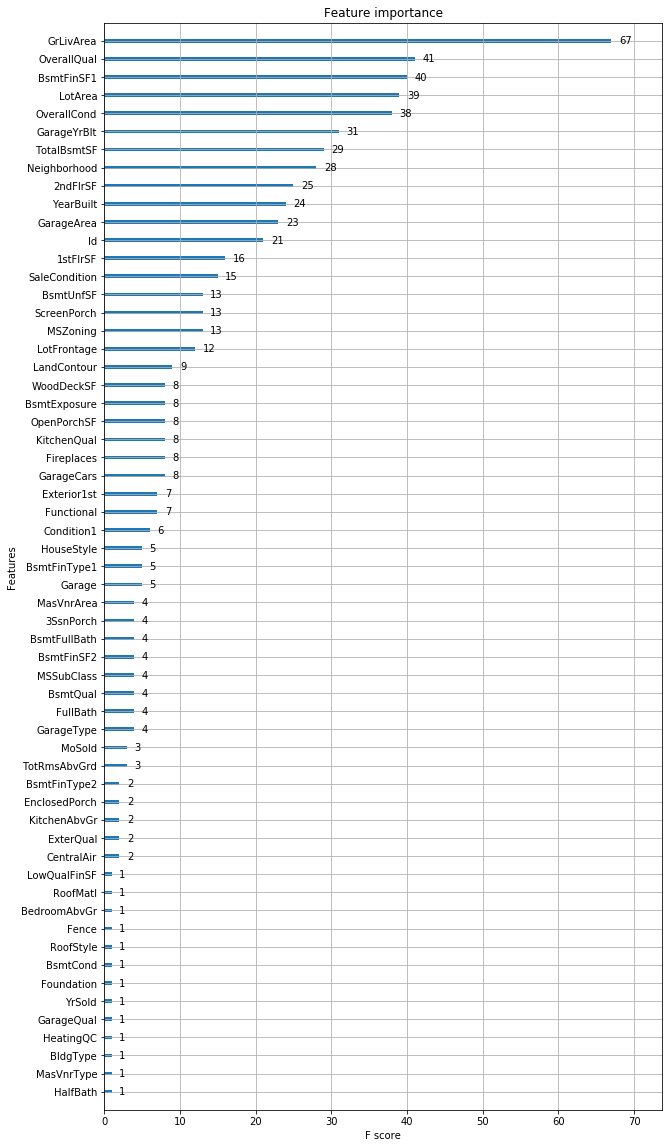

In [48]:
from numpy import loadtxt
from xgboost import plot_importance
from matplotlib import pyplot

xgboost.fit(train_l[list(test.columns)], y)
# plot feature importance
fig, ax = plt.subplots(1,1,figsize=(10,20))
plot_importance(xgboost, ax = ax)

pyplot.show()

In [49]:
feature_list = list(test.columns)
for ftr in ['LowQualFinSF','RoofMati','BedroomAbvGr','Fence','RoofStyle',
            'BsmtCond','Foundation','YrSold','GarageQual','HeatingQC',
            'BldgType','MasVnrType','HalfBath'
           ]:
    try:
        feature_list.remove(ftr)
    except:
        pass
baseline = update_baseline(baseline = baseline, ftr = feature_list)

[23:57:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean: 0.13055056426313955, std: 0.009378979069790959
Getting WORSE at -0.99% (old = 0.12927275515682654)


## Submission file

In [50]:
import category_encoders as ce




In [51]:
target_ftr = ['Neighborhood','MSZoning','Condition1','Condition2',
              'HouseStyle','OverallQual','OverallCond','ExterQual']

train_l = label_encode(train)[feature_list]
test_l = label_encode(test)[feature_list]

target_enc = ce.TargetEncoder(cols=target_ftr)
target_enc.fit(train_l[target_ftr], y)

# Transform the features, rename the columns with _target suffix, and join to dataframe
train_l = train_l.join(target_enc.transform(train_l[target_ftr]).add_suffix('_target'))
test_l = test_l.join(target_enc.transform(test_l[target_ftr]).add_suffix('_target'))
feature_list = [x for x in list(test_l.columns) if x not in target_ftr]

In [52]:


xgboost.fit(train_l[feature_list].fillna(0),y)
pred = xgboost.predict(test_l[feature_list].fillna(0))

result = pd.DataFrame({'Id': test.Id, 'SalePrice': pred})
result.to_csv('submission.csv',index = False)

[23:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
